In [1]:
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
seed1_path = 'models/neuralhash_128x96_seed1.dat'

seed1 = open(seed1_path, 'rb').read()[128:]
seed1 = np.frombuffer(seed1, dtype=np.float32)
seed1 = seed1.reshape([96, 128])

In [3]:
model = tf.saved_model.load('models/output')

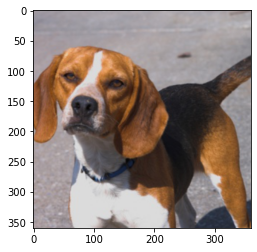

(1, 3, 360, 360)


In [4]:
# Preprocess image
image = Image.open('images/dog.png').convert('RGB')
image = image.resize([360, 360])

plt.imshow(image)
plt.show()

input_image = np.array(image).astype(np.float32) / 255.0
input_image = input_image * 2.0 - 1.0
input_image = input_image.transpose(2, 0, 1).reshape([1, 3, 360, 360])

print(input_image.shape)

In [5]:
output = model(image=input_image)

output['leaf/logits'].numpy().flatten()

array([ 7.27319031e+01, -1.19334860e+01,  4.59686279e+01, -1.63755760e+01,
       -9.98744659e+01, -4.18211441e+01,  1.40821381e+01,  4.33239174e+01,
        1.74896564e+01,  4.20998955e+01,  5.93914080e+00, -5.33996429e+01,
       -2.47213745e+01,  2.42439613e+01, -6.58417664e+01,  5.40841751e+01,
        2.02421227e+01,  1.96411476e+01,  3.64377708e+01, -1.73105183e+01,
       -4.75333176e+01,  2.93492336e+01,  5.98615313e+00,  6.01031532e+01,
        1.17661003e+02,  1.01173277e+01,  4.06534348e+01, -3.90310097e+01,
        3.42506599e+01, -1.13642830e+02,  5.01909180e+01, -4.18824310e+01,
       -9.63778496e+00,  3.19027209e+00,  1.00907738e+02, -3.10774350e+00,
        1.01301289e+01, -2.86705437e+01, -4.48113480e+01, -1.32252304e+02,
        7.31574478e+01, -7.91404918e-02,  5.99069328e+01, -6.36584663e+01,
        6.22398453e+01,  5.24967957e+01, -3.20476112e+01, -2.28955307e+01,
       -4.60929251e+00,  1.58358412e+01,  1.19200699e+02, -4.50718575e+01,
       -1.05076065e+01,  

In [6]:
hash_output = seed1.dot(output['leaf/logits'].numpy().flatten())
hash_bits = ''.join(['1' if it >= 0 else '0' for it in hash_output])
hash_hex = '{:0{}x}'.format(int(hash_bits, 2), len(hash_bits) // 4)

hash_hex

'59a34eabe31910abfb06f308'

In [7]:
def preprocess(image):
    image = image.resize([360, 360])
    input_image = np.array(image).astype(np.float32) / 255.0
    input_image = input_image * 2.0 - 1.0
    input_image = input_image.transpose(2, 0, 1).reshape([1, 3, 360, 360])

    return input_image

def inference(input_image):
    output = model(image=input_image)
    return output['leaf/logits']

def get_hash(output):
    hash_output = seed1.dot(output.numpy().flatten())
    hash_bits = ''.join(['1' if it >= 0 else '0' for it in hash_output])
    hash_hex = '{:0{}x}'.format(int(hash_bits, 2), len(hash_bits) // 4)

    return hash_hex

def postprocess(output):
    output = output.transpose(1, 2, 0)
    image = (output + 1) / 2.
    image = np.clip(image, 0, 1)
    image = Image.fromarray(image, 'RGB')
    plt.imshow(image)
    plt.show()

'11d9b097ac960bd2c6c131fa'

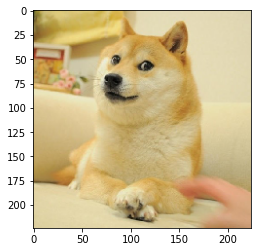

In [8]:
dog = Image.open('images/dog2.png')
plt.imshow(dog)

dog_hash = get_hash(inference(preprocess(dog)))
dog_hash

'38f7d495a9030a11f249e730'

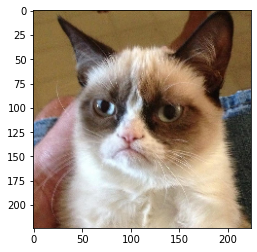

In [9]:
cat = Image.open('images/cat2.png')
plt.imshow(cat)

cat_hash = get_hash(inference(preprocess(cat)))
cat_hash

In [19]:
def get_hash_sim(logits, target, seed):
    target_hash = seed.dot(target.numpy().flatten())
    logits_hash = seed.dot(logits.numpy().flatten())
    sim = np.mean((target_hash > 0) * (logits_hash > 0))
    return sim

i = 0
lr = 1e-03

cat_input = preprocess(cat)
dog_logits = inference(preprocess(dog))
adv_arr = cat_input.copy()

while True:
    adv_t = tf.convert_to_tensor(adv_arr, dtype=tf.float32)

    with tf.GradientTape() as t:
        t.watch(adv_t)
        adv_logits = model(image=adv_t)['leaf/logits']
        loss = tf.nn.l2_loss(adv_logits - dog_logits)

    grad = t.gradient(loss, adv_t).numpy()
    adv_arr -= lr * grad

    adv_arr = np.clip(adv_arr, -1, 1)

    hash_sim = get_hash_sim(adv_logits, dog_logits, seed1)

    print(f'#{i}\tLoss={int(loss)}\tSimilariry={hash_sim}')

    if i % 100 == 0:
        adv_img = (adv_arr + 1.) / 2. * 255.
        Image.fromarray(adv_img[0].transpose(1, 2, 0).astype(np.uint8)).save(f"samples/{i}.png")
    i += 1

#0	Loss=300782	Similariry=0.28125
#1	Loss=279875	Similariry=0.2604166666666667
#2	Loss=266322	Similariry=0.23958333333333334
#3	Loss=252366	Similariry=0.25
#4	Loss=242443	Similariry=0.25
#5	Loss=232768	Similariry=0.2604166666666667
#6	Loss=225924	Similariry=0.2604166666666667
#7	Loss=220335	Similariry=0.2708333333333333
#8	Loss=215524	Similariry=0.2708333333333333
#9	Loss=210305	Similariry=0.2708333333333333
#10	Loss=205429	Similariry=0.2708333333333333
#11	Loss=199361	Similariry=0.28125
#12	Loss=195228	Similariry=0.28125
#13	Loss=191954	Similariry=0.2916666666666667
#14	Loss=189356	Similariry=0.2916666666666667
#15	Loss=186876	Similariry=0.2916666666666667
#16	Loss=182306	Similariry=0.2916666666666667
#17	Loss=175345	Similariry=0.28125
#18	Loss=169937	Similariry=0.2916666666666667
#19	Loss=165018	Similariry=0.2916666666666667
#20	Loss=160353	Similariry=0.2916666666666667
#21	Loss=156542	Similariry=0.2916666666666667
#22	Loss=153461	Similariry=0.3020833333333333
#23	Loss=150748	Similar

KeyboardInterrupt: 

'11d9b097ac960bd2c6c131fa'

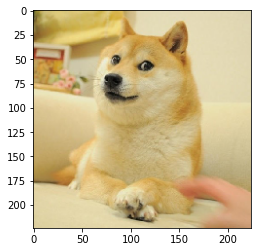

In [20]:
dog = Image.open('images/dog2.png')
plt.imshow(dog)

dog_hash = get_hash(inference(preprocess(dog)))
dog_hash

'11d9b097ac960bd2c6c131fa'

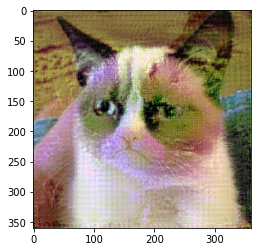

In [21]:
dog = Image.open('samples/3400.png')
plt.imshow(dog)

dog_hash = get_hash(inference(preprocess(dog)))
dog_hash